# Top 10% of Words that that correlate with each regressor
## 
### For each story there will be 3 'Top 10%', One for each type of regressor
#### 1) Concatenate words across all participants
#### 2) For each template, correlate it with each word. 
#### 3) Reorder the words based on the correlation
#### 4) Calculate the proportion of words from each priming type in the Top 10%
#### 5) Make a word cloud of the top 10%


#### 3/4/21


In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from scipy import stats


from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

#Import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%autosave 5

Autosaving every 5 seconds


# 0. Import recalls, and uncentered story and template vectors and sums 

In [30]:
# import recalls and sums
recalls = pickle.load( open( 'fr_recalls', "rb" ) )
sums = pickle.load( open( "fr_sums", "rb" ) )

#import non-centered story, template
templates = pickle.load( open( 'template_vectors', "rb" ) )
stories = pickle.load( open( 'actual_story_vectors', "rb" ) )

In [31]:
top_ten = {}

In [32]:
wikipath = 'rolando/wiki-news-300d-1M.vec'
wv_model = KeyedVectors.load_word2vec_format(wikipath)

In [33]:
wv_dim = 300

# FastText preprocessing, based on bittlingmayer/ft_wiki_preproc.py
# Remove special characters, put spaces between all tokens
SUB = ["s/’/'/g", "s/′/'/g", "s/''/ /g", "s/'/ ' /g", 's/“/"/g', 's/”/"/g', 's/"/ /g', "s/\\./ \\. /g", "s/<br \\/>/ /g", "s/, / , /g", "s/(/ ( /g", "s/)/ ) /g", "s/\\!/ \\! /g", "s/\\?/ \\? /g", "s/\\;/ /g", "s/\\:/ /g", "s/-/ - /g", "s/=/ /g", "s/=/ /g", "s/*/ /g", "s/|/ /g", "s/«/ /g", 
       "s/…/ /g", "s/‘/ /g", "s/í/ /g", "s/ñ/ /g", "s/\x84/ /g", "s/î/ /g", "s/ó/ /g", "s/\x83/ /g", "s/ï/ /g", "s/õ/ /g",
       "s/ò/ /g", "s/,/ /g", "s/ô/ /g", "s/\x92/ /g", "s/é/ /g", "s/\x8e/ /g", "s/â\x80¦/ /g", "s/\x91/ /g", "s/\x93/ /g",
       "s/\x94/ /g", "s/ã®/ /g", "s/ã¨/ /g", "s/ã©/ /g",
       "s/\â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x9d/ /g", "s/â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x98/ /g",
       "s/â/ /g"]

def __normalize_text(s):
    for sg in SUB:
        rep = sg.replace('\\','').split('/')
        s = s.replace(rep[1], rep[2])
    s = s.replace('/',' ')
    return s

def __spaces(s):
    return ' '.join(s.split())

def __digits(s):
    return ''.join(filter(lambda c: not c.isdigit(), s))

# def preproc(s):
#     return __punctuation(__spaces(__digits(__normalize_text(s.lower()))))

def preproc(s):
    return (__spaces(__digits(__normalize_text(s.lower()))))

def __punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def word2vecSent(sentence, model = 'fasttext'):
    wv_dim = 300 #for glove and fasttext
    
    if model == 'glove':
        wvmodel = glove_model
    elif model == 'fasttext':
        wvmodel = wv_model
        
    words = preproc(sentence).split(' ')
    wv = np.zeros((len(words), wv_dim))
    for i in range(len(words)):
        if words[i] in wvmodel.vocab:
            wv[i,:] = wvmodel.word_vec(words[i])
    
    return words, wv


# Concatenate words and word vectors in parallel across all participants

In [34]:
all_words = {}
all_wvs = {}
#priming type order
all_priming = {}

#iterate through all recalls in a story and concatente words and wvs of all stories
for key in recalls:
    words = np.zeros((0,1))
    wvs = np.zeros((0,300))
    priming = np.zeros((0,1))
    for i in range(0,3):
        for j in range(0,len(recalls[key][i])):
            p_words, p_wvs = word2vecSent(recalls[key][i][j][0])
            # reshape p_words
            p_words = np.array(p_words)
            p_words = p_words.reshape(p_words.shape[0],-1)
            p_priming = np.zeros(p_words.shape)
            p_priming = p_priming + i
            # stack p_words and p_wvs
            words = np.vstack((words, p_words))
            wvs = np.vstack((wvs, p_wvs))
            priming = np.vstack((priming, p_priming))
    all_words[key] = words
    all_wvs[key] = wvs
    all_priming[key] = priming 

# 2. Centering all words + story wvs + template wvs

In [35]:
#Concatenate all words from recall

concat = np.zeros((0,300))

for key in all_wvs:
    for i in range(0, len(all_wvs[key])):
        concat = np.vstack((concat, all_wvs[key][i]))
    
for key in stories:
    concat = np.vstack((concat, stories[key]))
    
for key in templates:
    concat = np.vstack((concat, templates[key]))
print(concat.shape)

centering_vec = np.mean(concat, axis = 0)

# template vectors

for key in templates:
    templates[key] = templates[key] - centering_vec
    
# recall vectors

for key in recalls:
    for i in range(0, len(all_wvs[key])):
        all_wvs[key][i] = all_wvs[key][i] - centering_vec
            
#story vectors

#make new dict with int key instead of string
int_stories = {}
for key in stories:
    int_stories[int(key)] = stories[key] - centering_vec

(37569, 300)


# raveling all_words and all_priming

In [36]:
for key in all_words:
    all_words[key] = np.ravel(all_words[key])
    all_priming[key] = np.ravel(all_priming[key])

# Regression?

In [37]:
## Regression 1:
    # same regression as final form of the partial correlations:
    ## cor(loc_template, wv - story)
    ## cor(soc_template, wv - story)
    ## cor(story_template, wv - loc - soc - all_other_story_templates)
regression1 = 0
## Regression 2:
    ## regress out everything from wvs
regression2 = 0
## Regression 3:
    ## regress out all other templates from each template
regression3 = 0

# *LOC* Top 10%


In [38]:
if regression1 == 1:
    print('1')
    new_wvs = copy.deepcopy(all_wvs)
    for key in all_wvs:
        n = all_wvs[key].shape[0]
        this_story = stories[str(key)].reshape(stories[str(key)].shape[0], -1)
        for i in range(0, n):
            output = np.copy(all_wvs[key][i])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(this_story, output)
            ## Is subtracting the intercept correct?? 
            new_wvs[key][i] = output - np.dot(model.coef_, this_story.T)- model.intercept_
elif regression2 == 1:
    print('2')
    schema_order = [1, 2, 3, 4, 10, 20, 30, 40]
    new_wvs = copy.deepcopy(all_wvs)
    # concat all story wvs
    story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]
    this_input = np.zeros((300,0))

    for story in story_order:
        this_input = np.concatenate((this_input, stories[str(story)].reshape(stories[str(story)].shape[0],-1)), axis = 1)

    for key in all_wvs:
        n = all_wvs[key].shape[0]
        new_input = np.copy(this_input)
        loc = key%10
        for schema in schema_order:
            if schema == loc:
                pass
            else:
                new_input = np.concatenate((new_input, templates[schema].reshape(templates[schema].shape[0],-1)), axis = 1)
        for i in range(0, n):
            output = np.copy(all_wvs[key][i])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(new_input, output)
            ## Is subtracting the intercept correct?? 
            new_wvs[key][i] = output - np.dot(model.coef_, new_input.T)- model.intercept_
elif regression3 == 1:
    new_wvs = copy.deepcopy(all_wvs)
    schema_order = [1, 2, 3, 4, 10, 20, 30, 40]

    new_templates = {}

    for template in templates:
        new_input = np.zeros((300,0))
        for other_template in schema_order:
            if other_template == template:
                pass
            else:
                new_input = np.concatenate((new_input, templates[other_template].reshape(templates[other_template].shape[0],-1)), axis = 1)
        ## regression 
        output = np.copy(templates[template])
        #output = output.reshape(output.shape[0],-1)
        model = LinearRegression().fit(new_input, output)
        ## Is subtracting the intercept correct?? 
        new_vec = output - np.dot(model.coef_, new_input.T)- model.intercept_
        new_templates[template] = new_vec
    
    templates = new_templates
    
else:
    print('0')
    new_wvs = copy.deepcopy(all_wvs)

0


In [39]:
### A. Correlate each word with the LOC WV
loc_cors = {}

for key in all_wvs:
    n = new_wvs[key].shape[0]
    this_loc_cors = np.zeros((n,1))
    loc = key%10
    this_loc = templates[loc].reshape(templates[loc].shape[0], -1)
    for i in range(0, n):
        this_wv = new_wvs[key][i].reshape(new_wvs[key][i].shape[0], -1)
        this_correl = np.corrcoef(this_loc.T, this_wv.T)
        this_loc_cors[i] = this_correl[0,1]
    loc_cors[key] = np.ravel(this_loc_cors)

## B. Use argsort() to get the indices of the Top 10%


In [40]:
top_words_priming = {}

for key in loc_cors:
    n = loc_cors[key].shape[0]
    top_ten_n = int(np.ceil(n*.1))
    # get the index of the top 10% of words
    this_index = loc_cors[key].argsort()[-top_ten_n:][::-1]
    # index the top words and the top priming
    top_words = all_words[key][this_index]
    top_priming = all_priming[key][this_index]
    # store the top words and the top priming
    top_words_priming[key] = {'loc':{'words': top_words, 'priming': top_priming}}

## C. *SOC* Top 10%

In [41]:
if regression2 == 1:
    print('2')
    new_wvs = copy.deepcopy(all_wvs)
    for key in all_wvs:
        n = all_wvs[key].shape[0]
        new_input = np.copy(this_input)
        soc = round(key/10)*10
        for schema in schema_order:
            if schema == soc:
                pass
            else:
                new_input = np.concatenate((new_input, templates[schema].reshape(templates[schema].shape[0],-1)), axis = 1)
        for i in range(0, n):
            output = np.copy(all_wvs[key][i])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(new_input, output)
            ## Is subtracting the intercept correct?? 
            new_wvs[key][i] = output - np.dot(model.coef_, new_input.T)- model.intercept_
else:
    print('o')
    pass

o


In [42]:
### A. Correlate each word with the SOC WV

soc_cors = {}

for key in all_wvs:
    n = new_wvs[key].shape[0]
    this_soc_cors = np.zeros((n,1))
    soc = round(key/10)*10
    this_soc = templates[soc].reshape(templates[soc].shape[0], -1)
    for i in range(0, n):
        this_wv = new_wvs[key][i].reshape(new_wvs[key][i].shape[0], -1)
        this_correl = np.corrcoef(this_soc.T, this_wv.T)
        this_soc_cors[i] = this_correl[0,1]
    soc_cors[key] = np.ravel(this_soc_cors)

## B. Use argsort() to get the indices of the Top 10%

for key in soc_cors:
    n = soc_cors[key].shape[0]
    top_ten_n = int(np.ceil(n*.1))
    # get the index of the top 10% of words
    this_index = soc_cors[key].argsort()[-top_ten_n:][::-1]
    # index the top words and the top priming
    top_words = all_words[key][this_index]
    top_priming = all_priming[key][this_index]
    # store the top words and the top priming
    top_words_priming[key]['soc'] = {'words': top_words, 'priming': top_priming}

## D. *Story* Top 10%

In [43]:
story_order = [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44]

if regression1 == 1:
    print('no')
    new_wvs = copy.deepcopy(all_wvs)
    for key in all_wvs:
        n = all_wvs[key].shape[0]
        loc = key%10
        soc = round(key/10)*10
        # location template
        l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
        # social template
        s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
        inputs = np.concatenate((l_temp, s_temp), axis = 1)
        # List the set of stories that share a schema with the stories
        shared_schema = []
        for story in story_order:
            this_loc = story%10
            this_soc = round(story/10)*10
            if story == key:
                pass
            elif this_loc == loc:
                shared_schema.append(story)
            elif this_soc == soc:
                shared_schema.append(story)
            else:
                shared_schema.append(story)
        # Iterate through the list
        for story in shared_schema:
            inputs = np.concatenate((inputs, stories[str(story)].reshape(stories[str(story)].shape[0],-1)), axis = 1)
        for i in range(0, n):
            output = np.copy(all_wvs[key][i])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(inputs, output)
            ## Is subtracting the intercept correct?? 
            new_wvs[key][i] = output - np.dot(model.coef_, inputs.T)- model.intercept_
elif regression2 == 1:
    new_wvs = copy.deepcopy(all_wvs)
    schema_order = [1, 2, 3, 4, 10, 20, 30, 40]

    this_input2 = np.zeros((300,0))

    for i in schema_order:
        this_input2 = np.concatenate((this_input2, templates[i].reshape(templates[i].shape[0],-1)), axis = 1)
    for key in all_wvs:
        n = all_wvs[key].shape[0]
        # Make the inputs of the regression
        new_input = np.copy(this_input2)
        # iterate through all the stories and concatenate to new_input except for the key
        for story in story_order:
            if story == key:
                pass
            else:
                new_input = np.concatenate((new_input, stories[str(story)].reshape(stories[str(story)].shape[0],-1)), axis = 1)
        for i in range(0, n):
            output = np.copy(all_wvs[key][i])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(new_input, output)
            ## Is subtracting the intercept correct?? 
            new_wvs[key][i] = output - np.dot(model.coef_, new_input.T)- model.intercept_
else:
    new_wvs = copy.deepcopy(all_wvs)


In [44]:
### A. Correlate each word with the STORY TEMPLATE WV

story_cors = {}

for key in all_wvs:
    n = all_wvs[key].shape[0]
    this_story_cors = np.zeros((n,1))
    this_story = stories[str(key)].reshape(stories[str(key)].shape[0], -1)
    for i in range(0, n):
        this_wv = new_wvs[key][i].reshape(new_wvs[key][i].shape[0], -1)
        this_correl = np.corrcoef(this_story.T, this_wv.T)
        this_story_cors[i] = this_correl[0,1]
    story_cors[key] = np.ravel(this_story_cors)

## B. Use argsort() to get the indices of the Top 10%

for key in story_cors:
    n = story_cors[key].shape[0]
    top_ten_n = int(np.ceil(n*.1))
    # get the index of the top 10% of words
    this_index = story_cors[key].argsort()[-top_ten_n:][::-1]
    # index the top words and the top priming
    top_words = all_words[key][this_index]
    top_priming = all_priming[key][this_index]
    # store the top words and the top priming
    top_words_priming[key]['story'] = {'words': top_words, 'priming': top_priming}

## Word Clouds

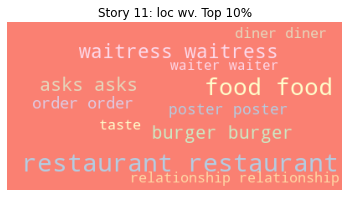

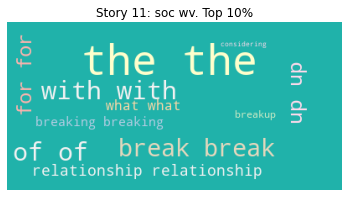

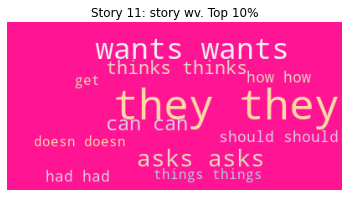

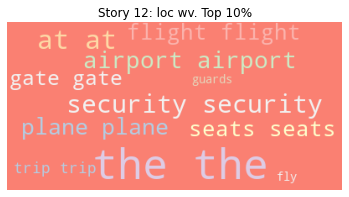

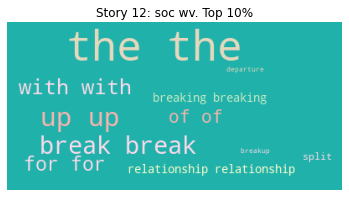

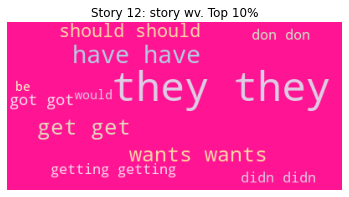

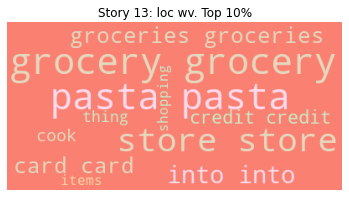

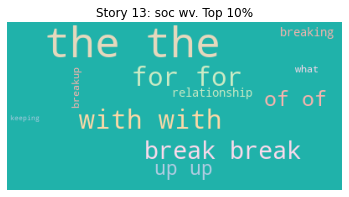

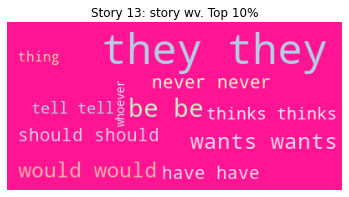

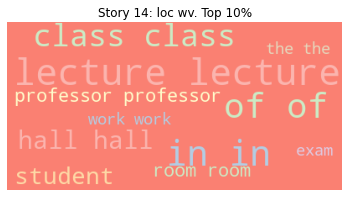

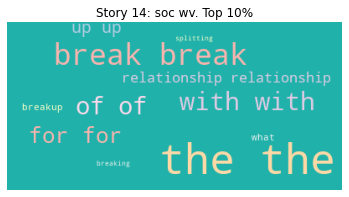

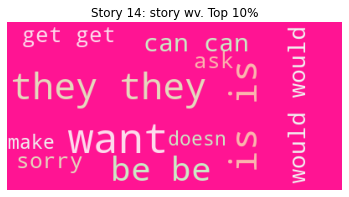

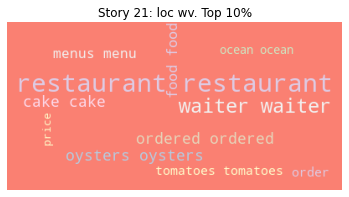

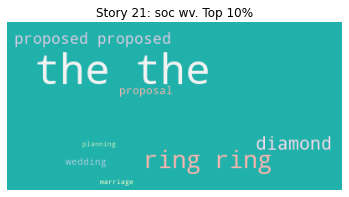

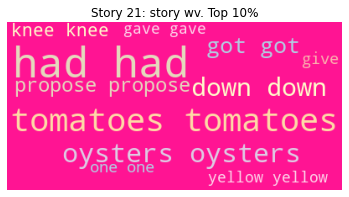

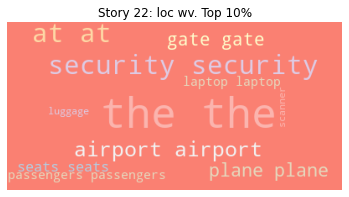

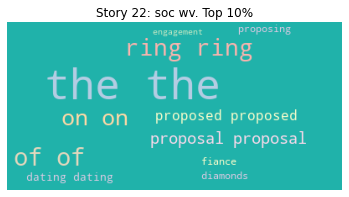

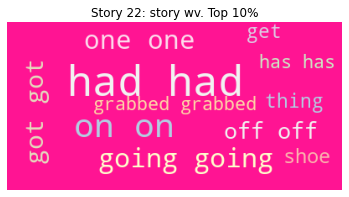

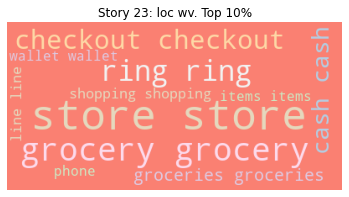

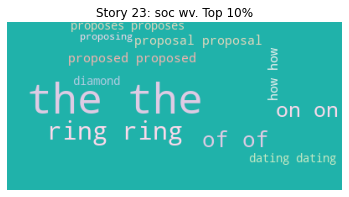

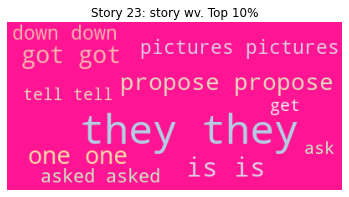

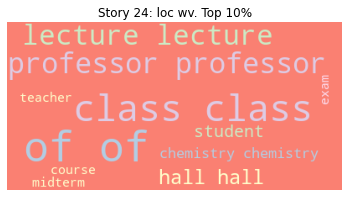

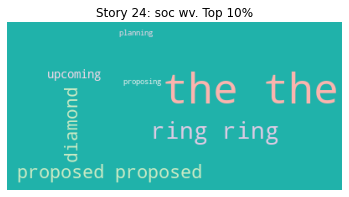

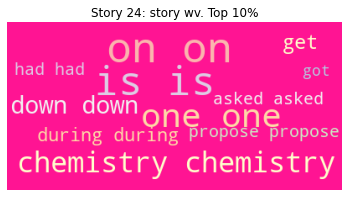

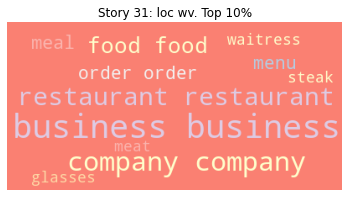

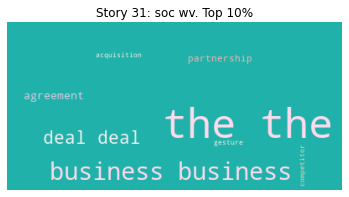

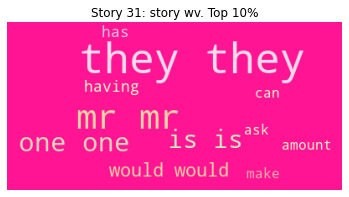

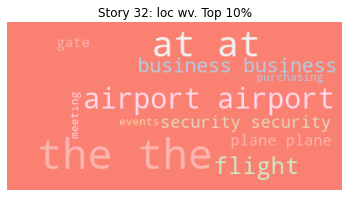

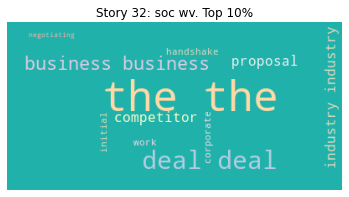

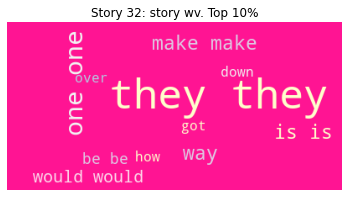

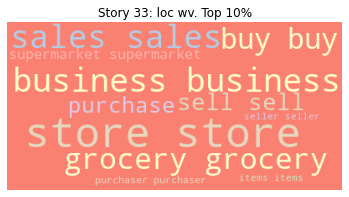

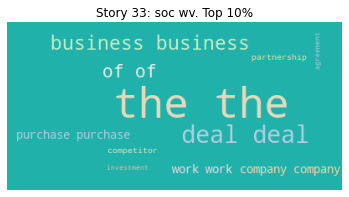

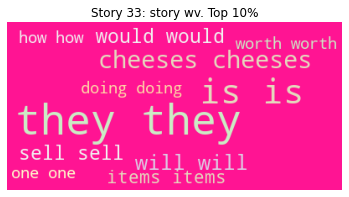

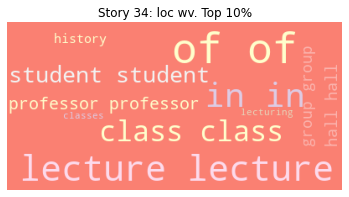

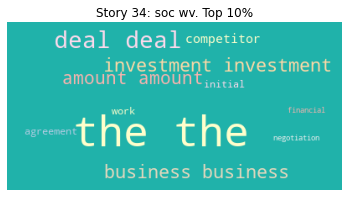

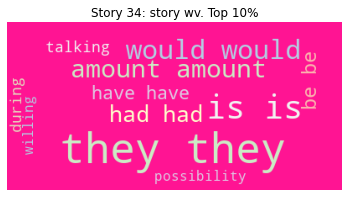

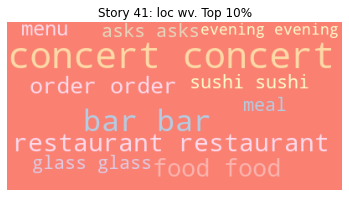

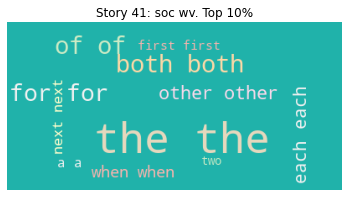

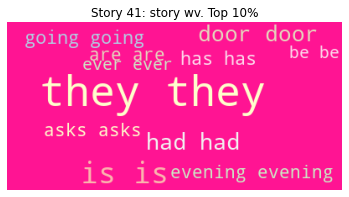

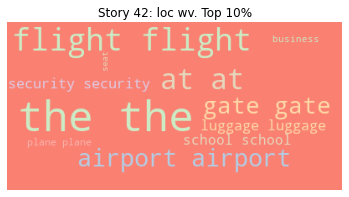

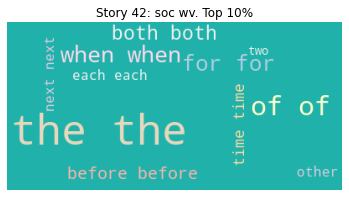

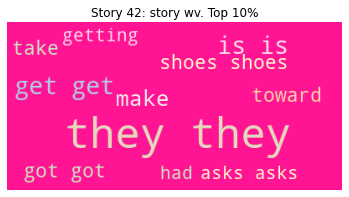

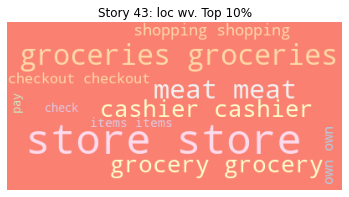

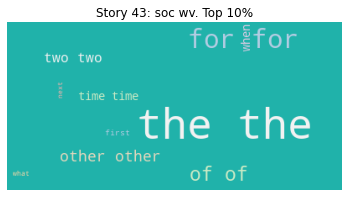

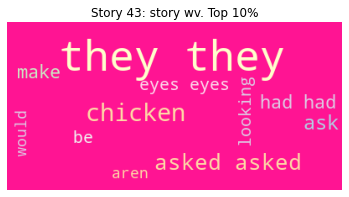

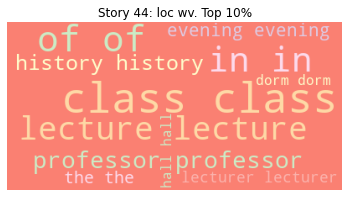

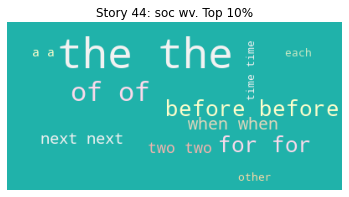

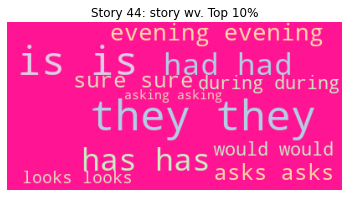

In [45]:
story_order = [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44]

STOPWORDS = ''

color = ['salmon', 'lightseagreen', 'deeppink']

for key in story_order:
    count = 0
    for template in top_words_priming[key].keys():
        these_words = top_words_priming[key][template]['words']
        str_words = ' '.join(map(str, these_words))   
        wordcloud = WordCloud(max_font_size=50, max_words=11, background_color=color[count], colormap='Pastel1', stopwords = STOPWORDS).generate(str_words)
        plt.figure()
        this_title = 'Story ' + str(key) + ": " + template + ' wv. Top 10%'
        plt.title(this_title)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        count += 1

# Proportion of words from each priming group

In [19]:
all_proportions = {}

for key in story_order:
    first_template = 0
    n = top_words_priming[key]['loc']['words'].shape[0]
    for template in top_words_priming[key].keys():
        proportions = np.zeros((3, 1))
        # loc proportion
        proportions[0] = np.sum(top_words_priming[key][template]['priming'] == 0)/n
        # soc proportion
        proportions[1] = np.sum(top_words_priming[key][template]['priming'] == 1)/n
        # story proportion
        proportions[2] = np.sum(top_words_priming[key][template]['priming'] == 2)/n
        if first_template == 0:
            all_proportions[key] = {template: proportions}
            first_template = 1
        else:
            all_proportions[key][template] =  proportions

In [20]:
# avg across all stories within the template types

avg_proportions = {}

for template in all_proportions[11].keys():
    concat_proportions = np.zeros((3,0))
    for story in story_order:
        concat_proportions = np.hstack((concat_proportions, all_proportions[story][template]))
    #avg across the stories
    this_avg = np.mean(concat_proportions, axis = 1)
    avg_proportions[template] = this_avg

In [21]:
avg_proportions

{'loc': array([0.30651483, 0.3594113 , 0.33407387]),
 'soc': array([0.33984442, 0.34388825, 0.31626733]),
 'story': array([0.31397618, 0.34033164, 0.34569219])}

In [22]:
avg_proportions

{'loc': array([0.30651483, 0.3594113 , 0.33407387]),
 'soc': array([0.33984442, 0.34388825, 0.31626733]),
 'story': array([0.31397618, 0.34033164, 0.34569219])}

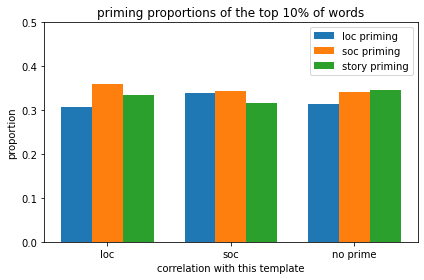

In [23]:
# loc weight
w0 = np.zeros((3,1))

# soc weight
w1 = np.zeros((3,1))

# story weight
w2 = np.zeros((3,1))

# assign values
# correlation with loc
w0[0] = avg_proportions['loc'][0]
w0[1] = avg_proportions['soc'][0]
w0[2] = avg_proportions['story'][0]

#proportion that are soc
w1[0] = avg_proportions['loc'][1]
w1[1] = avg_proportions['soc'][1]
w1[2] = avg_proportions['story'][1]

#proportion that are story
w2[0] = avg_proportions['loc'][2]
w2[1] = avg_proportions['soc'][2]
w2[2] = avg_proportions['story'][2]


w0 = w0.ravel()
w1 = w1.ravel()
w2 = w2.ravel()

#labels
labels = ['loc', 'soc', 'no prime']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, w0, width, label='loc priming')
rects2 = ax.bar(x + width, w1, width, label='soc priming')
rects3 = ax.bar(x + width*2, w2, width, label='story priming')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('proportion')
ax.set_xlabel('correlation with this template')
ax.set_title('priming proportions of the top 10% of words')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .5])
fig.tight_layout()

plt.show()


